## TFIDF and Topic Modeling

In [104]:
#Packages 
import pandas as pd
import numpy as np

#TFIDF packages
from sklearn.feature_extraction.text import TfidfVectorizer

#Topic modeling
import gensim
from gensim.models import LdaModel, CoherenceModel, LdaMulticore
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() #Visualize inside a notebook 

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

#Other
import warnings
import os 

In [26]:
#Functions

#TF IDF functions
def tfidf(corpus, titles, ngram_range = (1,1)):
    #This is a function to create a TFIDF matrix
    Tfidf=TfidfVectorizer(ngram_range=ngram_range)
    #Fit the vectorizer using the final processed documents 
    TFIDF_matrix=Tfidf.fit_transform(corpus)
    #Creating a dataframe from TFIDF matrix
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix

#Topic modeling
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
    return float(len(intersection))/float(len(union))

In [27]:
#Set a random seed for our topic modeling 
np.random.seed(500)

In [69]:
comments = pd.read_csv('comments_analysis.csv')
comments.head()

,author,body,sub_title,replies,score,ID,parent_ID,word_count,special_char_text_only,num_special_chars,num_stopwords,clean_body,clean_tokens,text_char
0,SophieCalle,"They're best taken like an abusive partner, ne...",Vatican says ‘sex-change’ surgery risks threat...,<praw.models.comment_forest.CommentForest obje...,211,kylxnae,t3_1byw23r,28,"They're best taken like an abusive partner, ne...",9,58.064516,well take like abusive partner trust treat rig...,"['well', 'take', 'like', 'abusive', 'partner',...",159
1,Mezahmay,Vatican threatens trans dignity and urges conf...,Vatican says ‘sex-change’ surgery risks threat...,<praw.models.comment_forest.CommentForest obje...,96,kylxq8c,t3_1byw23r,7,Vatican threatens trans dignity and urges conf...,1,14.285714,vatican threaten trans dignity urge conformity,"['vatican', 'threaten', 'trans', 'dignity', 'u...",53
2,JulieRose1961,The Catholic Church lost what little moral aut...,Vatican says ‘sex-change’ surgery risks threat...,<praw.models.comment_forest.CommentForest obje...,146,kylxrps,t3_1byw23r,19,The Catholic Church lost what little moral aut...,0,42.105263,catholic church lose little moral authority co...,"['catholic', 'church', 'lose', 'little', 'mora...",117
3,coralfire,"""Fuck them intersex kids."" - Pope Francis",Vatican says ‘sex-change’ surgery risks threat...,<praw.models.comment_forest.CommentForest obje...,130,kylvmrw,t3_1byw23r,7,"""Fuck them intersex kids."" - Pope Francis",4,16.666667,fuck intersex kid pope francis,"['fuck', 'intersex', 'kid', 'pope', 'francis']",41
4,One-Organization970,"Ah yes, the global cabal of pedophiles in ren ...",Vatican says ‘sex-change’ surgery risks threat...,<praw.models.comment_forest.CommentForest obje...,86,kyly7zr,t3_1byw23r,31,"Ah yes, the global cabal of pedophiles in ren ...",3,35.483871,ah yes global cabal pedophile ren faire costum...,"['ah', 'yes', 'global', 'cabal', 'pedophile', ...",190


### Topic Modeling

Here we will form topics from the text. Topic modeling is a method to extract hidden topics. Latent Dirichlet Allocation (LDA) is an unsupervised learning algorithm for topic modeling, part of the Gensim package.
LDA is a generative probabilistic model similar to Naive Bayes. It represents topics as word probabilities and allows for uncovering of latent or hidden topics as it clusters the words based on their co-occurrence in a respective document. 

We collect the texts, clean them, break them into tokens, build a dictionary that gives each token a unique ID, and that is used to create a corpus or BOW representing the frequency of the tokens.

We use this dictionary and corpus to build a range of topics and find the optimal number of topics. The last step is to find the distribution of topics in each document. 


In [85]:
#Convert each row to a list 
comments['clean_tokens'] = comments['clean_tokens'].apply(lambda doc: doc.split())

In [87]:
#The two main inputs to the LDA topic model are the dictionary and the corpus
#Apply the dictionary object from Gensim, which maps each word to its unique ID
#No empty tokens, all the tokens are strings, but emojis cause problems 
dictionary = Dictionary(comments.clean_tokens)

In [89]:
#Let's filter out low frequency and high frequency tokens, and limit the vocabulary if we wish
#no_below = tokens in less than 5 documents are filtered out
#no_above = tokens in more than 50% of the total corpus are removed
#keep_n = None (will keep all tokens for now)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [90]:
#Construct the corpus using the dictionary from above and the doc2bow function
#We count the # of occurrences of each distinct word, convert word to its integer word id, return result as sparse vector
corpus = [dictionary.doc2bow(doc) for doc in comments['clean_tokens']]

In [91]:
#Use LDA multicore (which does parallel processing)
#We'll run it once and then test a range of topics
lda_model = LdaMulticore(corpus = corpus,
                         id2word = dictionary,
                         iterations=50, #Iterates over corpus 50 times to optimize model parameters
                         num_topics=10, #Number of topics to test
                         random_state=42,
                         workers=4,
                         passes=10 #Model will pass through corpus 10 times during training
                         )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


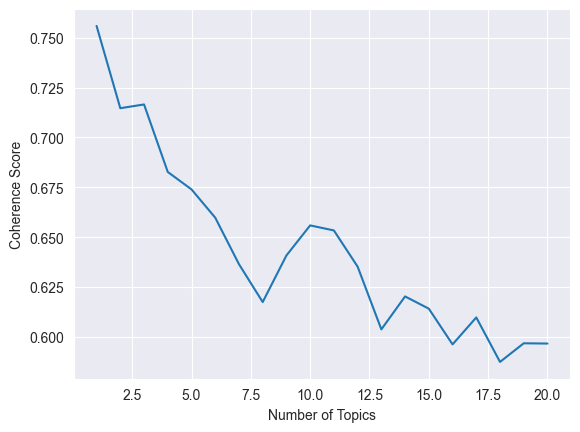

In [92]:
#One of the parameters of LDA models is how many topics to have, we want to test a range 
#How to evaluate topics? 
#The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence); values above 0.5 are fairly good 

#We will test 20 topics
num_topics = list(range(21)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}

topics = []
score = []

for i in num_topics:
    print(i)
    LDA_models[i] = LdaMulticore(corpus=corpus,
                                 id2word = dictionary,
                                 iterations=50, #Iterates over corpus 50 times to optimize model parameters
                                 num_topics=i, #Number of topics to test
                                 random_state=42,
                                 workers=4,
                                 passes=10 #Model will pass through corpus 10 times during training
                                 )
    cm = CoherenceModel(model=LDA_models[i], 
                        corpus=corpus,
                        texts=comments.clean_tokens,
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    shown_topics = LDA_models[i].show_topics(num_topics=1,
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
plt.plot(topics, score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

#When looking at coherence score it is best to go with the maximum value

In [93]:
#But we still want coherent topics
#Topic Coherence measures a single topic by measuring the degree of semantic similarity between high scoring words in the topic

coherences = [CoherenceModel(model=LDA_models[i], texts=comments.clean_tokens, corpus=corpus, dictionary=dictionary, coherence='c_v').get_coherence() for i in num_topics[:-1]]


In [94]:
#To ensure we have distinct topics, we minimize Jaccard similarity
#We then calculate LDA topic stability 

LDA_stability = {}

for i in range(0, len(num_topics) - 1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))
        
        jaccard_sims.append(sims)
    
    LDA_stability[num_topics[i]] = jaccard_sims
    

mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [95]:
#We want high coherence and low stability scores
print(coherences)
print(mean_stabilities)

[0.7559225029572267, 0.7146627626399144, 0.7165422286136661, 0.6826944765330154, 0.6739481670073809, 0.6597724716414249, 0.6364561881289637, 0.6174539853823506, 0.6408266371032966, 0.6558922693910245, 0.653363058156945, 0.6352111476484469, 0.6037555776907023, 0.6202802189558997, 0.6141333931167029, 0.5962329843353797, 0.6097423386252939, 0.5874383409468478, 0.596784614020709]
[0.5789473684210527, 0.2, 0.6666666666666666, 0.7647058823529411, 0.2, 0.5789473684210527, 0.15384615384615385, 0.07142857142857142, 0.07142857142857142, 0.0, 0.07142857142857142, 0.1111111111111111, 0.1111111111111111, 0.034482758620689655, 0.0, 0.034482758620689655, 0.034482758620689655, 0.0, 0.034482758620689655]


In [96]:
#We want to find the difference between coherences and Jaccard scores
#The ideal number of topics is the diff between the two metrics (we take the maximum of coh_sta_diffs)
#If there is more than one max value that are the same, we choose the one with the fewer number of topics for simplicity 

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] #Limit topics to the # of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] #choose fewer topics in case there are multiple maxes
ideal_topic_num = num_topics[ideal_topic_num_index]

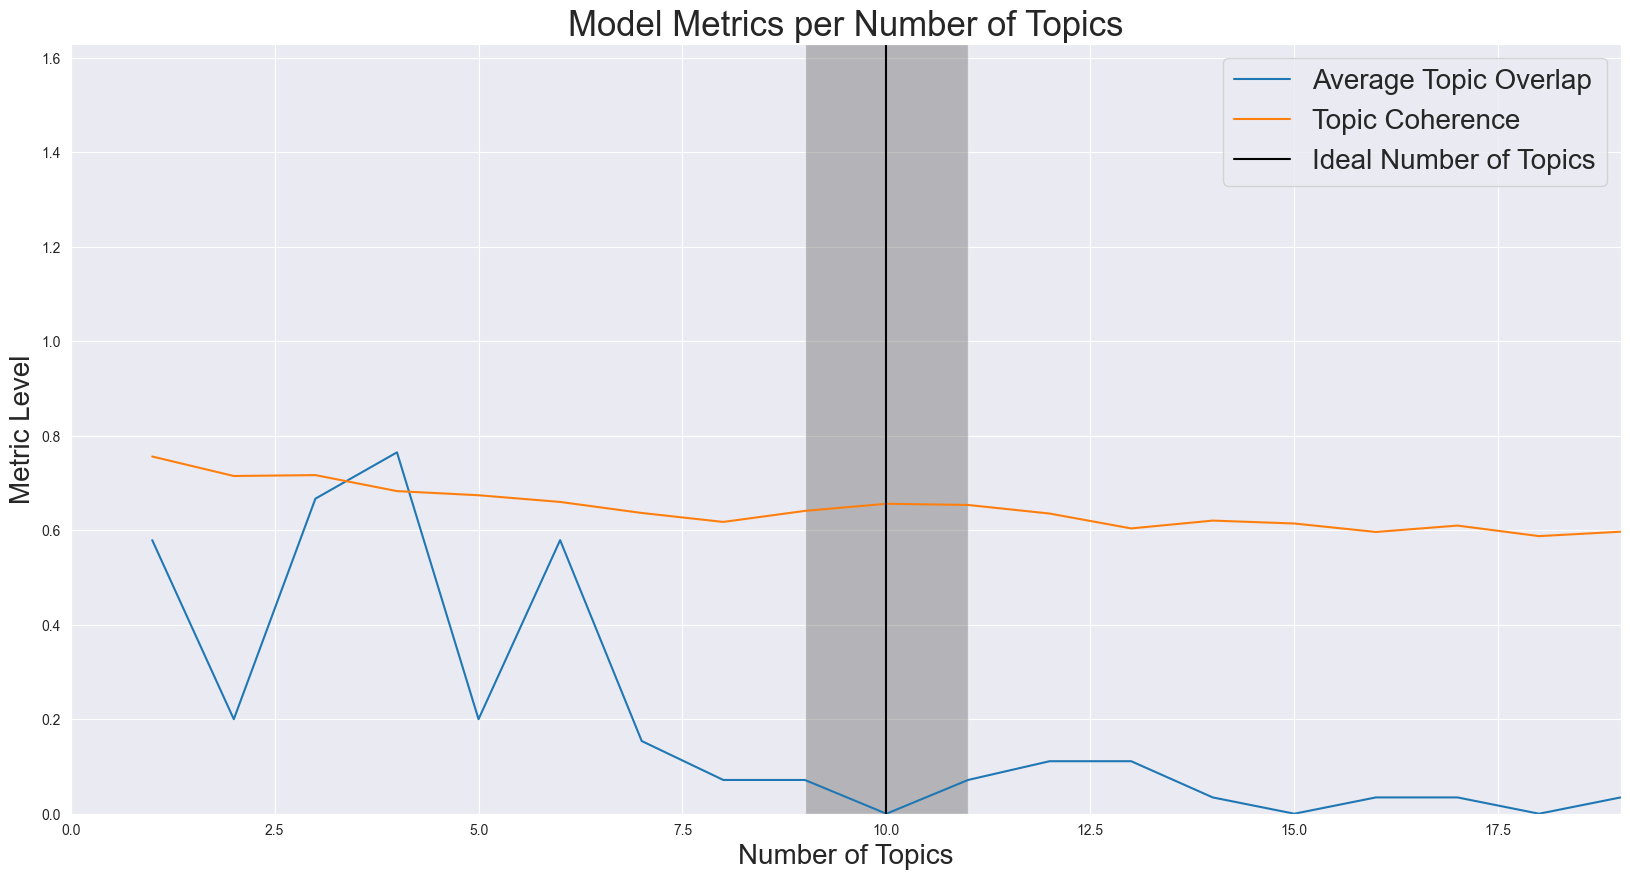

In [97]:
#We want the ideal number of topics
#Ideal number is the greatest difference between stability and coherence
#We will plot it here

plt.figure(figsize=(20, 10))

ax = sns.lineplot(x=num_topics[:-1],
                  y=mean_stabilities,
                  label="Average Topic Overlap")

ax = sns.lineplot(x=num_topics[:-1],
                  y=coherences,
                  label="Topic Coherence")

ax.axvline(x=ideal_topic_num,
          label="Ideal Number of Topics",
          color="black")

ax.axvspan(xmin=ideal_topic_num - 1,
           xmax=ideal_topic_num + 1,
           alpha=0.5,
           facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 + max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([0, num_topics[-1]-1])

ax.axes.set_title("Model Metrics per Number of Topics", fontsize=25)
ax.set_ylabel("Metric Level", fontsize=20)
ax.set_xlabel("Number of Topics", fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [98]:
#Getting a dataframe for similarity and coherence 
#This shows the number of topics, its coherence score, and its similarity score
#Want the number of topics with the highest coherence and lowest similarity score

cohsim = {"Topic":num_topics[:-1],
          "Coherence": coherences,
          "Similarity": mean_stabilities}

cohsim = pd.DataFrame(cohsim, columns = ['Topic', "Coherence", "Similarity"])

cohsim.to_csv('cohsim.csv')

cohsim.head()

,Topic,Coherence,Similarity
0,1,0.755923,0.578947
1,2,0.714663,0.200000
2,3,0.716542,0.666667
3,4,0.682694,0.764706
4,5,0.673948,0.200000


In [101]:
#Acquiring the top keywords for each topic and topic probabilities for each comment
#Since 10 is the ideal number of topics 
lda_10 = LDA_models[10]

In [113]:
#Printing it out
for i, topic in lda_10.show_topics(formatted=True,
                                  num_topics=10, 
                                  num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.021*"'people'," + 0.013*""'"," + 0.012*"'go']" + 0.010*"'know'," + 0.008*"'good'," + 0.007*"'😭'," + 0.007*"'think'," + 0.006*"'work'," + 0.006*"'like'," + 0.006*"'😭']"

1: 0.037*"['thank'," + 0.027*"'good'," + 0.026*"'hope'," + 0.020*"'luck'," + 0.020*"'️'," + 0.018*"'❤'," + 0.017*"'️']" + 0.016*"['good'," + 0.015*"'thank'," + 0.014*"'wish',"

2: 0.031*"'surgery'," + 0.022*"'insurance'," + 0.021*"'year'," + 0.016*"'cover'," + 0.016*"'pay'," + 0.012*"'get'," + 0.011*"'surgeon'," + 0.009*"'not'," + 0.009*"'work'," + 0.009*"'month',"

3: 0.031*"'tran'," + 0.024*"'people'," + 0.020*"'woman'," + 0.018*"'gender'," + 0.018*"'not'," + 0.013*"'man'," + 0.011*"'cis'," + 0.010*"'trans'," + 0.010*"'transition'," + 0.009*"'want',"

4: 0.015*"'not'," + 0.013*"'care'," + 0.013*"'state'," + 0.010*"'right'," + 0.009*"'medical'," + 0.007*"'people'," + 0.006*"'support'," + 0.006*"'s'," + 0.006*"'kid'," + 0.006*"'law',"

5: 0.062*"'surgery'," + 0.017*"'want'," + 0.012*"'not'," + 0.011*"'people'," + 0

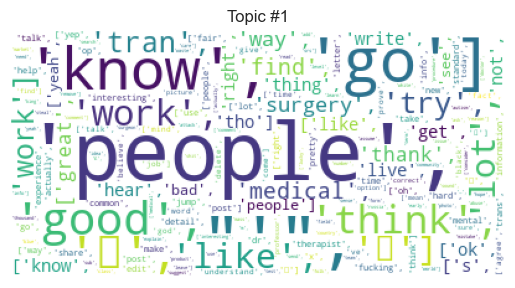

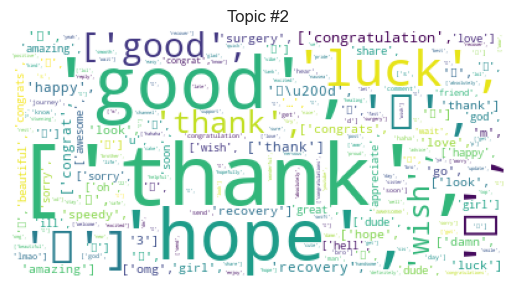

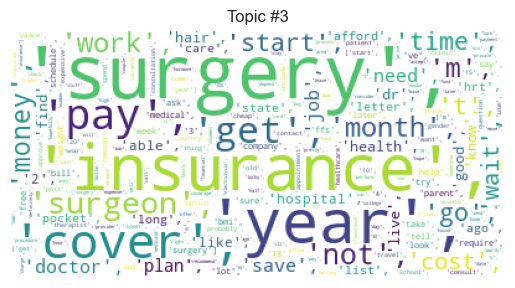

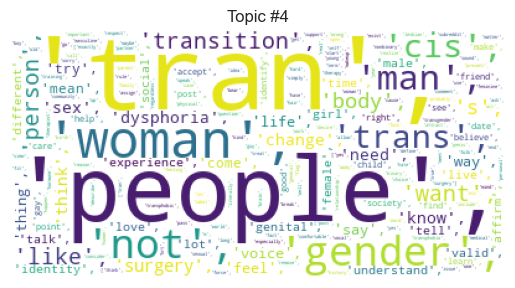

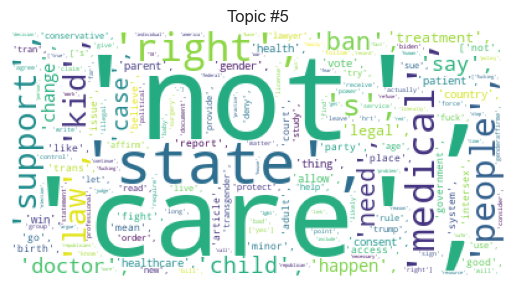

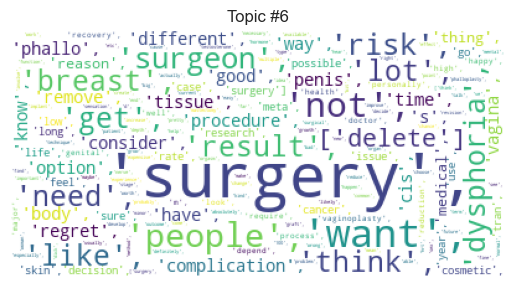

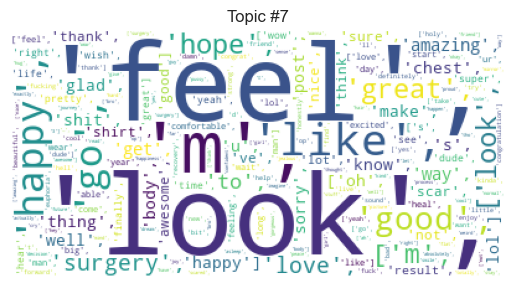

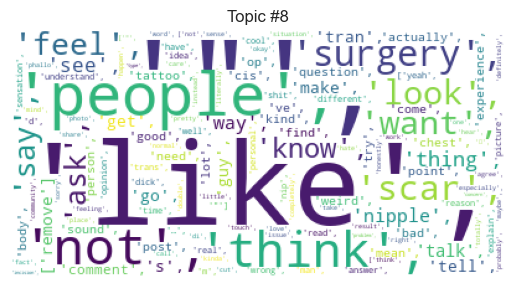

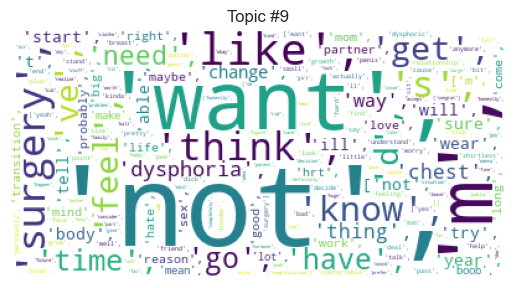

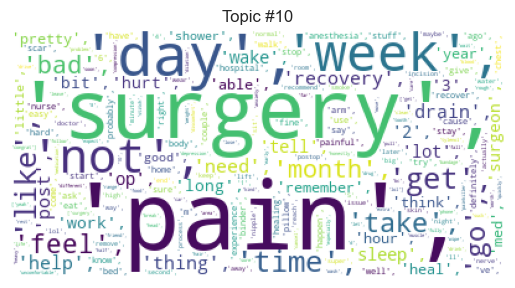

In [105]:
#Word Clouds for each topic
for t in range(lda_10.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_10.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()

In [106]:
#Getting a dataframe with the topic scores for each text 
corpus_lda = lda_10[corpus]
all_topics = lda_10.get_document_topics(corpus_lda, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(corpus_lda)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

#Saving scores to csv
all_topics_df.to_csv('topic_scores.csv')

In [107]:
#Let's examine a text and a topic
print(comments.clean_body[0])
print(lda_10[corpus][0])
#Per our text, it belongs to topic 4 

well take like abusive partner trust treat right baby come ve change right old way
[(0, 0.0062526963), (1, 0.0062521636), (2, 0.006253156), (3, 0.006254147), (4, 0.39637175), (5, 0.006252806), (6, 0.0062536336), (7, 0.26778746), (8, 0.2920684), (9, 0.0062537543)]


In [108]:
#Let's visualize the topics and words in each topic for topic 6 
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/mona/PycharmProjects/TGNB_Reddit/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=76642) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mona/PycharmProjects/TGNB_Reddit/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=76642) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mona/PycharmProjects/TGNB_Reddit/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=76642) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mona/PycharmProjects/TGNB_Reddit/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=76642) is multi-threaded, use of fork() may lead to deadlocks in the child.
  

The above chart represents our topics as circles. They have been drawn using a dimensionality reduction technique called PCA. The goal is to have a distance in order to avoid overlapping and make each circle unique. When I hover over a circle different words are displayed on the right, showing word frequency (blue) and estimated term frequency within the selected topic (red). Topics closer to each other are more related.

In [111]:
#Add topics to the dataframe 
#We can create a new column in the df which has the most probable topic that each text belongs to
#We can add the most probable topic by running through each text comment
comments['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(comments['clean_tokens']))]

In [112]:
#Whats the topic distribution?
comments.topic.value_counts()

topic
0    39055
2     6305
1     5213
3     4900
5     2550
4     1664
6     1530
7      890
8      474
9      216
Name: count, dtype: int64